In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [3]:
df_original = pd.read_csv("stonad_mottakere_kommune_2010_2022.csv")

In [4]:
df_original

,aar,kommune_nr,kommune_navn,kjonn_kode,stonad,mottaker_antall
0,2022,1101,Eigersund,K,Dagpenger,103.0
1,2022,1101,Eigersund,K,Arbeidsavklaringspenger,222.0
2,2022,1106,Haugesund,K,Dagpenger,133.0
3,2022,1106,Haugesund,K,Arbeidsavklaringspenger,618.0
4,2022,1108,Sandnes,K,Dagpenger,423.0
...,...,...,...,...,...,...
20027,2021,5443,Båtsfjord,M,Arbeidsavklaringspenger,24.0
20028,2020,5444,Sør-Varanger,M,Arbeidsavklaringspenger,110.0
20029,2021,5444,Sør-Varanger,M,Arbeidsavklaringspenger,116.0
20030,2020,5444,Sør-Varanger,K,Arbeidsavklaringspenger,155.0


In [5]:
df = df_original

# Rask oversikt

In [6]:
numerical_columns = df.select_dtypes(include=[float, int])
max_values = numerical_columns.max()
min_values = numerical_columns.min()
mean_values = numerical_columns.mean()

print("Maximum values for numerical columns:")
print(max_values)

print("\nMinimum values for numerical columns:")
print(min_values)

print("\nMean values for numerical columns:")
print(mean_values)

Maximum values for numerical columns:
aar                2022.0
kommune_nr         5444.0
mottaker_antall    2277.0
dtype: float64

Minimum values for numerical columns:
aar                2010.0
kommune_nr          101.0
mottaker_antall       5.0
dtype: float64

Mean values for numerical columns:
aar                2015.754543
kommune_nr         1699.657997
mottaker_antall     108.596615
dtype: float64


In [7]:
non_numerical_columns = df.select_dtypes(exclude=[float, int])
unique_values_counts = non_numerical_columns.nunique()

print("\nNumber of unique values for non-numerical columns:")
print(unique_values_counts)


Number of unique values for non-numerical columns:
kommune_navn    450
kjonn_kode        4
stonad            2
dtype: int64


In [8]:
df['kjonn_kode'].unique()

array(['K', 'Kvinne', 'M', 'Mann'], dtype=object)

In [9]:
df.isna().sum()

aar                0
kommune_nr         0
kommune_navn       0
kjonn_kode         0
stonad             0
mottaker_antall    4
dtype: int64

In [10]:
df[df.isna().any(axis=1)]

,aar,kommune_nr,kommune_navn,kjonn_kode,stonad,mottaker_antall
1315,2015,101,Halden,M,Dagpenger,NaN
1324,2015,101,Halden,K,Dagpenger,NaN
10312,2015,101,Halden,K,Arbeidsavklaringspenger,NaN
10313,2015,101,Halden,M,Arbeidsavklaringspenger,NaN


In [11]:
df = df.dropna()

# Fiks kjønn
Velger å summere verdiene

In [12]:
df["kjonn_kode"] = df["kjonn_kode"].replace(to_replace={"Kvinne": "K", "Mann": "M"})

/tmp/ipykernel_641/1533305532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["kjonn_kode"] = df["kjonn_kode"].replace(to_replace={"Kvinne": "K", "Mann": "M"})


In [279]:
non_numerical_columns = df.select_dtypes(exclude=[float, int])
unique_values_counts = non_numerical_columns.nunique()

print("\nNumber of unique values for non-numerical columns:")
print(unique_values_counts)


Number of unique values for non-numerical columns:
kommune_navn    450
kjonn_kode        2
stonad            2
dtype: int64


# Stønad over tid

In [280]:
df_tid = df.pivot_table(index="aar", columns="stonad", values="mottaker_antall", aggfunc="sum")

df_tid.reset_index(inplace=True)
df_tid["Total Stonad"] = df_tid.iloc[:, 1:].sum(axis=1)
df_tid.set_index("aar", inplace=True)

(0.0, 200000.0)

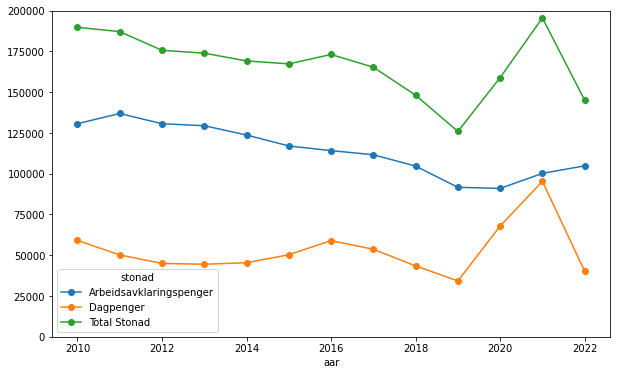

In [281]:
df_tid.plot(kind="line", marker="o", figsize=(10, 6))
plt.ylim(0,200000)

# Stønadsfordeling

In [282]:
test = df.groupby(["kommune_navn", "stonad"])["mottaker_antall"].mean().reset_index()
test[test["kommune_navn"] == "Bergen"]

,kommune_navn,stonad,mottaker_antall
58,Bergen,Dagpenger,14.666667


In [283]:
test = df.groupby(["kommune_navn", "stonad"])["mottaker_antall"].mean().reset_index()
test = test.pivot(index="kommune_navn", columns="stonad", values="mottaker_antall")
test.reset_index(inplace=True)
test.columns = ["kommune_navn", "Arbeidsavklaringspenger", "Dagpenger"]
test["Totalt"] = test["Arbeidsavklaringspenger"]+test["Dagpenger"]
test["Dagpenger_%"] = (test["Dagpenger"]/test["Totalt"])*100
test = test.dropna()
test

,kommune_navn,Arbeidsavklaringspenger,Dagpenger,Totalt,Dagpenger_%
0,Aarborte - Hattfjelldal,17.384615,7.857143,25.241758,31.127558
1,Agdenes,21.750000,12.466667,34.216667,36.434486
2,Alstahaug,89.615385,47.269231,136.884615,34.532172
3,Alta,393.692308,127.653846,521.346154,24.485430
4,Alvdal,23.769231,8.470588,32.239819,26.273684
...,...,...,...,...,...
445,Østre Toten,277.961538,72.307692,350.269231,20.643461
446,Øvre Eiker,305.500000,131.692308,437.192308,30.122284
447,Øyer,64.038462,30.961538,95.000000,32.591093
448,Øygarden,185.423077,109.461538,294.884615,37.120125


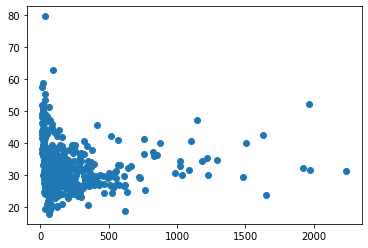

In [284]:
plt.scatter(test["Totalt"], test["Dagpenger_%"])

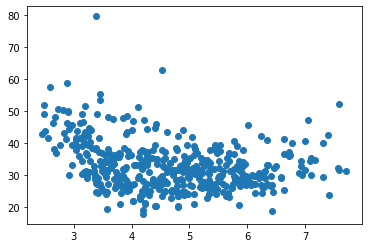

In [285]:
plt.scatter(np.log(test["Totalt"]), test["Dagpenger_%"])

In [286]:
x_train, x_test, y_train, y_test = train_test_split(test["Totalt"], test["Dagpenger_%"], test_size=0.33, random_state=42)
x_train = x_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

In [297]:
x_train, x_test, y_train, y_test = train_test_split(np.log(test["Totalt"]), test["Dagpenger_%"], test_size=0.33, random_state=42)
x_train = x_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

## Lineær

In [288]:
reg = LinearRegression().fit(x_train, y_train)

In [289]:
slope = reg.coef_
intercept = reg.intercept_
slope, intercept

(array([-1.64811981]), 40.67394051500981)

In [290]:
r2_score(y_test, reg.predict(x_test))

0.10906024513510582

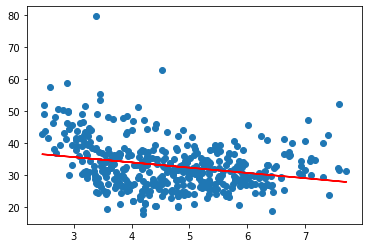

In [291]:
plt.plot(x_train, reg.predict(x_train), color="r")
plt.scatter(np.log(test["Totalt"]), test["Dagpenger_%"])

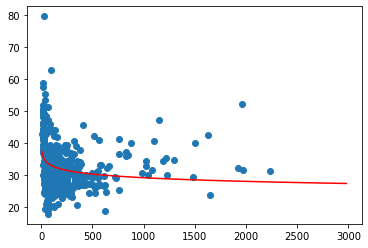

In [292]:
x_vals = np.linspace(2,8).reshape(-1,1)
plt.plot(np.exp(x_vals), reg.predict(x_vals), color="r")
plt.scatter(test["Totalt"], test["Dagpenger_%"])

## Polynomisk

In [302]:
poly = PolynomialFeatures(degree=2, include_bias=True)
x_train_trans = poly.fit_transform(x_train)
x_test_trans = poly.transform(x_test)

In [303]:
reg2 = LinearRegression().fit(x_train_trans, y_train)

In [304]:
slope = reg2.coef_
intercept = reg2.intercept_
slope, intercept

(array([  0.        , -19.30564723,   1.79597851]), 81.4223225027848)

In [305]:
r2_score(y_test, reg2.predict(x_test_trans))

0.22002831538223777

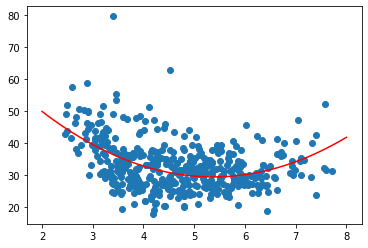

In [306]:
x_vals = np.linspace(2,8).reshape(-1,1)
x_vals_trans = poly.transform(x_vals)
plt.plot(x_vals, reg2.predict(x_vals_trans), color="r")
plt.scatter(np.log(test["Totalt"]), test["Dagpenger_%"])

## Mer nøyaktig

In [312]:
x_train_array = np.array(x_train)
x_test_array = np.array(x_test)
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

x_train_array = sm.add_constant(x_train_array)
x_test_array = sm.add_constant(x_test_array)
x_train_array = np.column_stack((x_train_array, x_train_array[:, 1] ** 2, x_train_array[:, 1] ** 3))
x_test_array = np.column_stack((x_test_array, x_test_array[:, 1] ** 2, x_test_array[:, 1] ** 3))

In [314]:
model = sm.OLS(y_train_array, x_train_array[:,0:2])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     21.85
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           4.48e-06
Time:                        22:34:45   Log-Likelihood:                -1013.2
No. Observations:                 298   AIC:                             2030.
Df Residuals:                     296   BIC:                             2038.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6739      1.708     23.808      0.000      37.312      44.036
x1            -1.6481      0.353     -4.675      0.000      -2.342      -0.954
==============================================================================
Omnibus:                       83.442   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.626
Skew:                           1.158   Prob(JB):                     1.58e-67
Kurtosis:                       7.406   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [316]:
model = sm.OLS(y_train_array, x_train_array[:,0:3])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     40.98
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           1.98e-16
Time:                        22:35:15   Log-Likelihood:                -987.27
No. Observations:                 298   AIC:                             1981.
Df Residuals:                     295   BIC:                             1992.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.4223      5.665     14.373      0.000      70.273      92.571
x1           -19.3056      2.381     -8.108      0.000     -23.991     -14.620
x2             1.7960      0.240      7.486      0.000       1.324       2.268
==============================================================================
Omnibus:                       87.536   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.340
Skew:                           1.131   Prob(JB):                     4.77e-90
Kurtosis:                       8.293   Cond. No.                         424.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='X', ylabel='Y'>

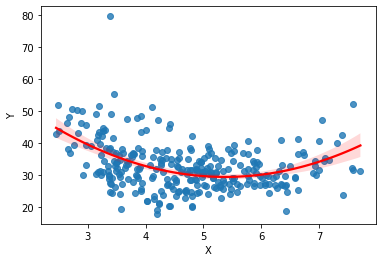

In [341]:
regplot_data = pd.DataFrame({"Y":y_train, "X":x_train.flatten()})
sns.regplot(x="X", y="Y", data = regplot_data, order=2, line_kws=dict(color="r"))

In [19]:
df_1 = df[df["aar"] == 2020]
df_1

,aar,kommune_nr,kommune_navn,kjonn_kode,stonad,mottaker_antall
2092,2020,301,Oslo,K,Dagpenger,7.0
4509,2020,1101,Eigersund,M,Dagpenger,87.0
4522,2020,1101,Eigersund,K,Dagpenger,120.0
4559,2020,1106,Haugesund,K,Dagpenger,294.0
4570,2020,1106,Haugesund,M,Dagpenger,335.0
...,...,...,...,...,...,...
20022,2020,5442,Unjárga - Nesseby,M,Arbeidsavklaringspenger,6.0
20024,2020,5443,Båtsfjord,M,Arbeidsavklaringspenger,19.0
20026,2020,5443,Båtsfjord,K,Arbeidsavklaringspenger,25.0
20028,2020,5444,Sør-Varanger,M,Arbeidsavklaringspenger,110.0


In [21]:
df_2 = df_1[df_1["stonad"] == "Dagpenger"]
df_2

,aar,kommune_nr,kommune_navn,kjonn_kode,stonad,mottaker_antall
2092,2020,301,Oslo,K,Dagpenger,7.0
4509,2020,1101,Eigersund,M,Dagpenger,87.0
4522,2020,1101,Eigersund,K,Dagpenger,120.0
4559,2020,1106,Haugesund,K,Dagpenger,294.0
4570,2020,1106,Haugesund,M,Dagpenger,335.0
...,...,...,...,...,...,...
10286,2020,5442,Unjárga - Nesseby,M,Dagpenger,7.0
10289,2020,5443,Båtsfjord,K,Dagpenger,69.0
10290,2020,5443,Båtsfjord,M,Dagpenger,41.0
10292,2020,5444,Sør-Varanger,K,Dagpenger,77.0


In [26]:
df_2.groupby("kommune_navn").sum().sort_values("mottaker_antall")

,aar,kommune_nr,mottaker_antall
kommune_navn,,,
Modalen,2020,4629,5.0
Træna,2020,1835,5.0
Namsskogan,2020,5044,6.0
Leka,2020,5052,6.0
Solund,2020,4636,6.0
...,...,...,...
Fredrikstad,4040,6008,1567.0
Lillestrøm,4040,6060,1742.0
Bærum,4040,6048,1966.0
